In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import itertools as it
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from skimage import filters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from tensorflow.keras.metrics import top_k_categorical_accuracy
from collections import namedtuple
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import sklearn
from sklearn.preprocessing import LabelEncoder

simplefilter("ignore", category=ConvergenceWarning)

In [3]:
folder_train = Path('masked-facerecognition/AFDB_face_dataset/AFDB_face_dataset/')
folder_val = Path('masked-facerecognition/AFDB_masked_face_dataset/AFDB_masked_face_dataset/')

In [4]:
def get_files(path):
    files = []
    labels = []

    for fld in os.listdir(path):
        for f in os.listdir(path / fld):
            files.append(str(path / fld / f))
            labels.append(fld)
    return files, labels

train_files, train_labels = get_files(folder_train)
val_files, val_labels = get_files(folder_val)

In [5]:
df_train = pd.DataFrame({'in_file': train_files, 'class': train_labels})
df_val = pd.DataFrame({'in_file': val_files, 'class': val_labels})
df_val = df_val[df_val['class'].isin(df_train['class'])]

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

df_train['class_id'] = label_encoder.transform(df_train['class'])
df_val['class_id'] = label_encoder.transform(df_val['class'])

# df_train['width'] = df_train.in_file.apply(lambda x: cv2.imread(x).shape[1])
# df_train['height'] = df_train.in_file.apply(lambda x: cv2.imread(x).shape[0])

csv = df_train

# Basic data exploration

## Class balance exploration

In [6]:
class_grouped = csv.groupby('class_id')

samples_per_class = class_grouped.count().in_file.to_numpy()
classes_id = class_grouped.count().index

## Row image exploration

Here is a visualization of raw images. Since we are working with classification task, we are interested in bounding box areas only.

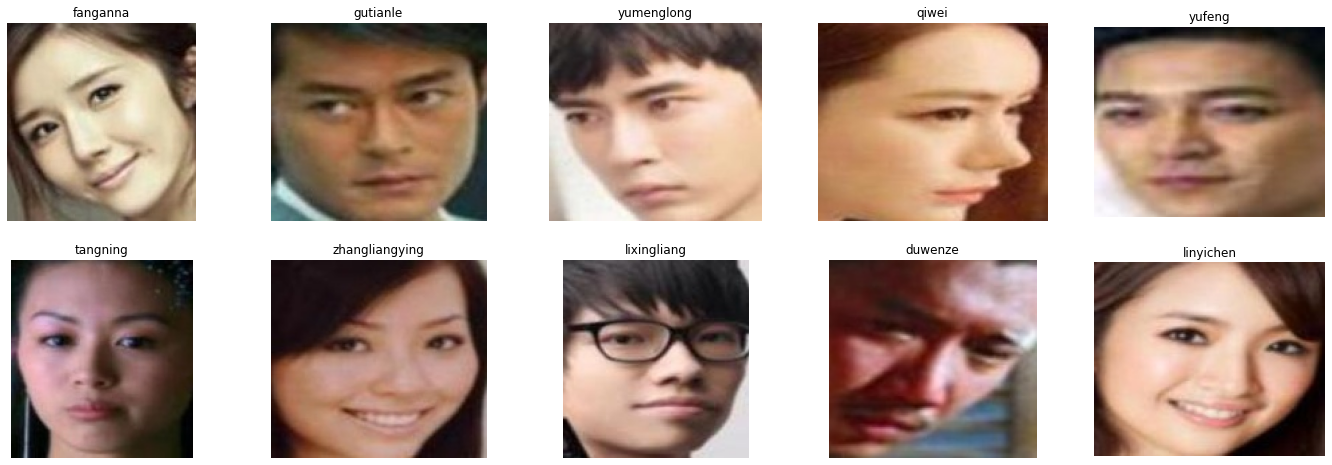

In [7]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(24, 8))

for _ax, (idx, row) in zip(ax.ravel(), csv.sample(10).iterrows()):
    img = cv2.imread(row.in_file)
    
    _ax.imshow(img[..., ::-1])
    
    _ax.set_title(row['class'])
    
    _ax.axis('off')

Cropped images have different size. We need to resize it in order to form batches. What size is the best tradeoff between quality and size?

In [8]:
def class_id_to_str(cls_id):
    return csv[csv.class_id == cls_id].iloc[0]['class']

# Train & validation split

Now it's time to split the whole dataset into the train and validation splits. Taking into account an extremely small amount of sample per class, a random split over the whole CSV is not the best approach.

Let's split samples randomly per each class. In that approach we will definitly obtain uniformly balanced train and validation splits.

In [9]:
csv_train = df_train.sample(frac=1)
csv_val = df_val.sample(frac=1)

# Lightway check that we have no data leakage
for train_file in csv_train.in_file:
    for val_file in csv_val.in_file:
        assert not train_file == val_file

# Preapre dataset loader

In that point we have two DataFrame - train and validation. Since we are going to work with DL models we need to have efficient data pipeline. Loading data on fly allows us to avoid bottleneck and speedup overall training routine.

TensorFlow efficient data pipeline seems to the best soltuion (at least for TF :)).
TensorFlow data pipelines works like built-in python generator. We aregoing to work with images. bviously it is not a solution to load the whole dataset into the memory. So, we just load paths to images. Then, map function, that load imags, crop it. After that we may map addition data preprocessing step (normaliation, augmentation etc). At the end we pack samples into batches. **Note,** no image has been loaded jet.
Image will be loaded when you start iterating over the dataset. It is very efficient, that tensorflow handles all routines about multiproecessing, paralleling. You don't pay attention to it at all. GPU trains your model while CPU loads the next batches to it. No botleneck here.

Folow that link for detailed tutorial about [TensorFlow data pipelines](https://www.tensorflow.org/guide/data).

Let's define some basic utils to help us working with DataFrames defined above.

In [10]:
# Load imabe from path and crop it according to boundig box
# file: string Tensor ,path to the image
# label: class label of sample
def crop_image(file, label):
    img_data = tf.io.read_file(file)
    img = tf.io.decode_jpeg(img_data, channels=3)
    
    img = tf.image.resize(img, [224, 224])
    img /= 255
    
    return img, label

In [11]:
# Generator that yields image path, bounding box and class label
# _csv: DataFrame to yield samples from
def file_bb_lbl_gen(_csv: pd.DataFrame):
    def generator():
        for idx, row in _csv.iterrows():
            file = row.in_file

            label = row.class_id

            yield file, label
    return generator


# Makes TensorFlow datasets from a DataFrame
# _csv: DataFrame to make dataset from
def make_img_lbl_ds(_csv):
    ds = tf.data.Dataset.from_generator(file_bb_lbl_gen(_csv), output_types=(tf.string, tf.int32))
    # Now ds yields tuples of (file_path, bounding_box, label)
    ds = ds.map(crop_image) # Maps image loading and cropping to the dataset
    # Now ds yields tuples of (image, label)
    
    return ds


# Perofrm augmentation to the sample
def aug(img, label):
    x = tf.image.random_flip_left_right(img)
    return x, label

You may ask why there is redundant arguments in preprocessing utils (e.g. label)? Te answer is simple. Since we form samples (which consists of image and label). Function that will be mapped to such dataset sould have signature which reflects dataset sample - image and label in our case.

Now, let's create dataset objects

In [12]:
# We keep original datasets without batches. Thet's why names are started from undescroe
_train_dataset, _val_dataset, = make_img_lbl_ds(csv_train), make_img_lbl_ds(csv_val)

# _train_dataset = make_img_lbl_ds(csv_train)

# Build your input pipelines. Here we perform shufling, batching and prefetching
train_dataset = _train_dataset.map(aug).shuffle(1024).batch(256).prefetch(2)
train_dataset_no_aug = _train_dataset.batch(256).prefetch(2)

val_dataset = _val_dataset.batch(256).prefetch(4)

## Visualize samples from dataset pipeline

We need carefully inspect data at each step. Let's unsure that data from TensorFlow pipelines looks good.

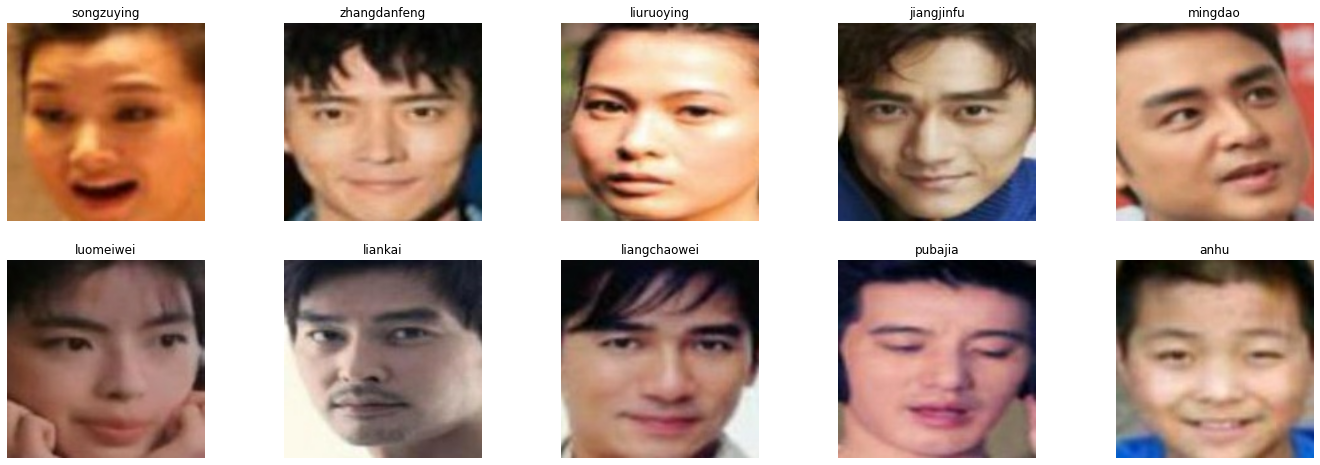

In [13]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(24, 8))

for _ax, (img, label) in zip(ax.ravel(), _train_dataset.take(10)):
    _ax.imshow(img)
    _ax.set_title(class_id_to_str(label.numpy()))
    _ax.axis('off')

# Build model

In [14]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/vgg16/efficientnet/b5/feature-vector/1", trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=None),
    tf.keras.layers.Dense(256, activation=None),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

## Train and Evaluate

We need a special loss function in order to force model learn meaningfull embadings. 
The goal of the triplet loss[[2]](https://arxiv.org/abs/1503.03832) is to make sure that:
* Two examples with the same label have their embeddings close together in the embedding space
* Two examples with different labels have their embeddings far away.

So, triplet loss takes three embadings - *A*, *P* and *N*
* A - random embading sample
* P - embading that represents the same class as an *A*
* N - embading that represents other class

In [15]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.05),
    loss=tfa.losses.TripletSemiHardLoss())

# Train model

In [16]:
 Train the network
save_cb = tf.keras.callbacks.ModelCheckpoint('./best_val', save_best_only=True, monitor='val_loss', save_weights_only=True)

step_train = len(df_train) // 256
step_val = len(df_val) // 256

history1 = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[save_cb]) 

model.load_weights('./best_val')
model.layers[0].trainable = True

history2 = model.fit(train_dataset, epochs=70, validation_data=val_dataset, verbose=2, callbacks=[save_cb]) 

In [17]:
model.load_weights('./best_val')

# Training & validation loss

Let's explore training and validation losses

In [18]:
# fig, ax = plt.subplots(figsize=(24, 4))

# ax.plot(np.arange(1, 21, 1), history1.history['loss'], label='Frozen backbone (train)', c='tab:blue', linestyle='--')
# ax.plot(np.arange(21, 41, 1), history2.history['loss'], c='tab:red', label='Fine tune backbone (train)', linestyle='--')

# ax.plot(np.arange(1, 21, 1), history1.history['val_loss'], label='Frozen backbone (validation)', c='tab:blue')
# ax.plot(np.arange(21, 41, 1), history2.history['val_loss'], c='tab:red', label='Fine tune backbone (validation)')

# ax.grid()
# ax.legend()
# ax.set_title('Training loss graph')
# ax.set

# ax.set_ylabel('Loss', fontsize=16)
# ax.set_xlabel('Epoch', fontsize=16);

# Evaluate model

Since we have saves the best model checkpoint it makes sence to perform evaluation using that checkpoints

In [19]:
model.load_weights('./best_val')

train_loss = model.evaluate(train_dataset_no_aug)
val_loss = model.evaluate(val_dataset)

print(f'Loss | Train: {train_loss:0.4f} \t Validation: {val_loss:0.4f}')

6/6 [==============================] - 141s 23s/step - loss: 0.9901
Loss | Train: 0.9903 	 Validation: 0.9901


In [22]:
val_thresh = filters.threshold_otsu(np.concatenate([val_pos_dists, val_neg_dists]))
train_thresh = filters.threshold_otsu(np.concatenate([train_pos_dists, train_neg_dists]))

print(f'Threshold for train set: {train_thresh:0.5f} Threshold for test set: {val_thresh:0.5f} \t Validation threshold {(np.abs(train_thresh - val_thresh) / train_thresh)*100:0.2f}%')

Threshold for train set: 0.00562 Threshold for test set: 0.00447 	 Validation threshold 20.51%


# Binary accuracy

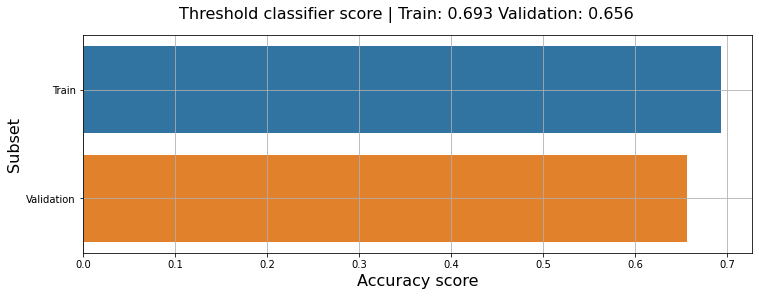

In [24]:
def threshold_classifier(thresh):
    def classify(x):
        y = np.where(x < thresh, 1, 0)
        return y
    return classify


BinClassifierDesc = namedtuple('BinClassifierDesc', ['acc', 'fpr', 'tpr', 'auc'])

thresh_clf = threshold_classifier(train_thresh)

train_dists = np.concatenate([train_pos_dists, train_neg_dists])
val_dists = np.concatenate([val_pos_dists, val_neg_dists])
# test_dists = np.concatenate([test_pos_dists, test_neg_dists])

train_dist_gt_labels = np.concatenate([np.full_like(train_pos_dists, 1), np.full_like(train_neg_dists, 0)])
val_dist_gt_labels = np.concatenate([np.full_like(val_pos_dists, 1), np.full_like(val_neg_dists, 0)])
# test_dist_gt_labels = np.concatenate([np.full_like(test_pos_dists, 1), np.full_like(test_neg_dists, 0)])

def thresh_classifier_eval(dists, lbls):
    y_pred = thresh_clf(dists)
    acc = accuracy_score(lbls, y_pred)
    return acc
    
thresh_train_score = thresh_classifier_eval(train_dists, train_dist_gt_labels)
thresh_val_score = thresh_classifier_eval(val_dists, val_dist_gt_labels)
# thresh_test_score = thresh_classifier_eval(test_dists, test_dist_gt_labels)

fig, ax = plt.subplots(figsize=(12, 4))

sns.barplot([thresh_train_score, thresh_val_score], ['Train', 'Validation'])
ax.set_xlabel('Accuracy score', fontsize=16)
ax.set_ylabel('Subset', fontsize=16)
fig.suptitle(f'Threshold classifier score | Train: {thresh_train_score:0.3f} Validation: {thresh_val_score:0.3f}', fontsize=16)
ax.grid();

## Distance classifier

In [25]:
thresh_clf_finder = GridSearchCV(MLPClassifier(), param_grid={
    'hidden_layer_sizes': [(2,), (4,), (10,), (12,)],
    'activation': ['logistic', 'tanh', 'relu']
}, n_jobs=-1)

_train_dists = np.expand_dims(train_dists, axis=-1)

thresh_clf_finder.fit(_train_dists, train_dist_gt_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid

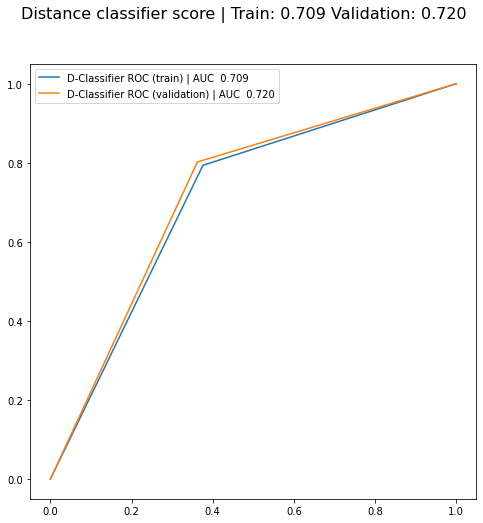

In [26]:
_val_dists = np.expand_dims(val_dists, axis=-1)
# _test_dists = np.expand_dims(test_dists, axis=-1)

BinClassifierDesc = namedtuple('BinClassifierDesc', ['acc', 'fpr', 'tpr', 'auc'])

def eval_bin_classifier(dists, lbls):
    _dists = np.expand_dims(dists, axis=-1)
    y_pred = thresh_clf_finder.best_estimator_.predict(_dists)
    fpr, tpr, _ = roc_curve(lbls, y_pred)
    auc_score = auc(fpr, tpr)
    score = thresh_clf_finder.best_estimator_.score(_dists, lbls)
    return BinClassifierDesc(score, fpr, tpr, auc_score)

# train_clf_pred_labels = thresh_clf_finder.best_estimator_.predict(_train_dists)
# val_clf_pred_labels = thresh_clf_finder.best_estimator_.predict(_val_dists)
# test_clf_pred_labels = thresh_clf_finder.best_estimator_.predict(_test_dists)

# train_clf_fpr, train_clf_tpr, _ = roc_curve(train_dist_gt_labels, train_clf_pred_labels)
# val_clf_fpr, val_clf_tpr, _ = roc_curve(val_dist_gt_labels, val_clf_pred_labels)
# test_clf_fpr, test_clf_tpr, _ = roc_curve(test_dist_gt_labels, test_clf_pred_labels)

# train_clf_auc = auc(train_clf_fpr, train_clf_tpr)
# val_clf_auc = auc(val_clf_fpr, val_clf_tpr)
# test_clf_auc = auc(test_clf_fpr, test_clf_tpr)

# train_score = thresh_clf_finder.best_estimator_.score(_train_dists, train_dist_gt_labels)
# val_score = thresh_clf_finder.best_estimator_.score(_val_dists, val_dist_gt_labels)
# test_score = thresh_clf_finder.best_estimator_.score(_test_dists, test_dist_gt_labels)

train_eval_bin_classifier = eval_bin_classifier(train_dists, train_dist_gt_labels)
val_eval_bin_classifier = eval_bin_classifier(val_dists, val_dist_gt_labels)
# test_eval_bin_classifier = eval_bin_classifier(test_dists, test_dist_gt_labels)


fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(train_eval_bin_classifier.fpr, train_eval_bin_classifier.tpr, label=f'D-Classifier ROC (train) | AUC {train_eval_bin_classifier.auc: 0.3f}')
ax.plot(val_eval_bin_classifier.fpr, val_eval_bin_classifier.tpr, label=f'D-Classifier ROC (validation) | AUC {val_eval_bin_classifier.auc: 0.3f}')
# ax.plot(test_eval_bin_classifier.fpr, test_eval_bin_classifier.tpr, label=f'D-Classifier ROC (test) | AUC {test_eval_bin_classifier.auc: 0.3f}')
ax.legend()
fig.suptitle(f'Distance classifier score | Train: {train_eval_bin_classifier.acc:0.3f} '
             f'Validation: {val_eval_bin_classifier.acc:0.3f} '
             , fontsize=16);

## Compare distance classifiers

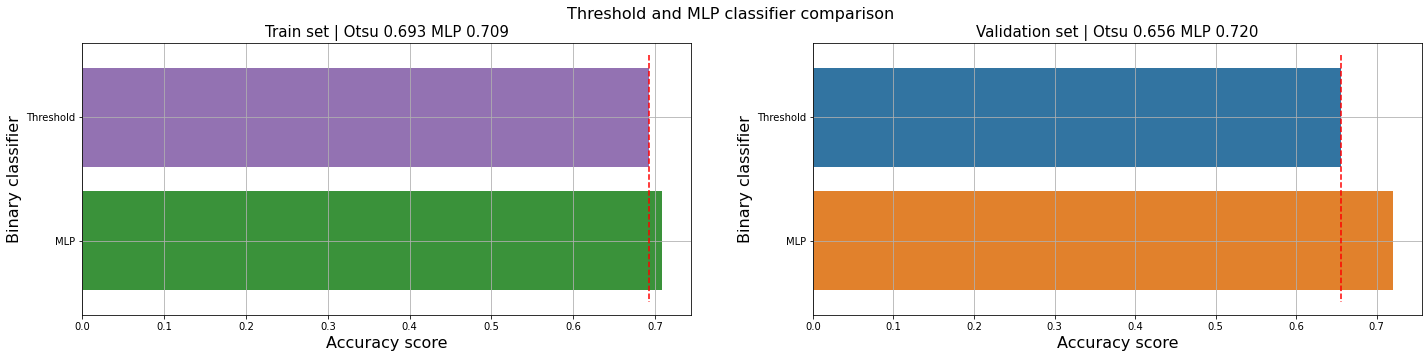

In [27]:
fig, ax = plt.subplots(figsize=(24, 5), ncols=2)

sns.barplot([thresh_train_score, train_eval_bin_classifier.acc], ['Threshold', 'MLP'], ax=ax[0], palette=['tab:purple', 'tab:green'])
sns.barplot([thresh_val_score, val_eval_bin_classifier.acc], ['Threshold', 'MLP'], ax=ax[1], palette=['tab:blue', 'tab:orange'])
# sns.barplot([thresh_test_score, test_eval_bin_classifier.acc], ['Threshold', 'MLP'], ax=ax[2], palette=['tab:grey', 'tab:red'])

ax[0].vlines(np.min([thresh_train_score, train_eval_bin_classifier.acc]), -0.5, 1.5, linestyle='--', color='r')
ax[1].vlines(np.min([thresh_val_score, val_eval_bin_classifier.acc]), -0.5, 1.5, linestyle='--', color='r')
# ax[2].vlines(np.min([thresh_test_score, test_eval_bin_classifier.acc]), -0.5, 1.5, linestyle='--', color='r')

ax[0].set_title(f'Train set | Otsu {thresh_train_score:0.3f} MLP {train_eval_bin_classifier.acc:0.3f}', fontsize=15)
ax[1].set_title(f'Validation set | Otsu {thresh_val_score:0.3f} MLP {val_eval_bin_classifier.acc:0.3f}', fontsize=15)
# ax[2].set_title(f'Test set | Otsu {thresh_test_score:0.3f} MLP {test_eval_bin_classifier.acc:0.3f}', fontsize=15)

for _ax in ax:
    _ax.set_xlabel('Accuracy score', fontsize=16)
    _ax.set_ylabel('Binary classifier', fontsize=16)
    _ax.grid()
    
fig.suptitle('Threshold and MLP classifier comparison', fontsize=16);

# Visualize

In [33]:
person = "guojunchen"
path = test[test.person==person]["path"].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = fr.predict(path)я
file_bytes = np.fromstring(base64.b64decode(result["frame"]), np.uint8)
output = cv2.imdecode(file_bytes,1)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(person)
plt.subplot(1, 2, 2)
plt.imshow(output)
print(result["predictions"][0]["confidence"])
plt.title("%s (%f)" % (result["predictions"][0]["person"], result["predictions"][0]["confidence"]))
plt.tight_layout()
plt.show()